## RECONSTRUCTION

In [1]:
import AnalogToDigital as ADC
import AnalogToDigital.deltaSigma as deltaSigma

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import signal
import _pickle as pickle
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable

import AnalogToDigital as ADC

from __future__ import division
from deltasigma import *


%load_ext autoreload
%autoreload 2

/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/__init__.py:919: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File

In [2]:
n_samples = 1 << 16   # number of sample pairs (x, y)
OSR = 32           # oversampling rate, must be integer
order_mash_block = [1, 1, 1]  # order of one mash block
order = len(order_mash_block)
n_lev = 2            # bit levels

# Expected Performance
systemOrder = np.sum(order_mash_block)
print(systemOrder)
DR = order * 6.02 + 1.76 + 10 * np.log10(2 * systemOrder + 1) - 20 * systemOrder * np.log10(np.pi) + 10 * (2 * systemOrder + 1) * np.log10(OSR)
ENOB = (DR - 1.76) / 6.02
print('Expected MSE: %f\nEffective Number of bits: %s' % (-DR, ENOB))

3
Expected MSE: -103.802487
Effective Number of bits: 16.95057915629368


/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/_realizeNTF.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T
/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/deltasigma/_simulateDSM.py:215: UserWarning: Using a slow implementation of simulateDSM
Refer to the docs for how to switch to a fast one
  'Refer to the docs for how to switch to a fast one')


freqIndex 258944


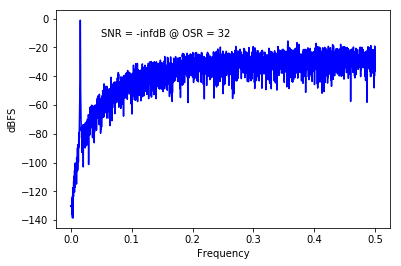

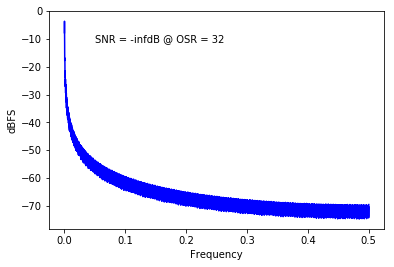

In [3]:
size = n_samples
fp = 1./(OSR * 2) * 1.
Ts = 1.
# Ts = 1. / 2. / fp / OSR


# input
input = ADC.system.Sin(Ts, 0.01, fp , 0, steeringVector=np.zeros(order))
# input = ADC.system.BandlimitedNoise(1e-8, 2*2*OSR, 0)

t = np.linspace(0., Ts * (size - 1) , size)
u = input.scalarFunction(t)
# u = u - np.mean(u)

ds = [deltaSigma.DeltaSigma(OSR, x, nlev = n_lev) for x in order_mash_block]
mash = deltaSigma.MASH(OSR, ds)
dsH = deltaSigma.DeltaSigma(OSR, systemOrder, nlev=n_lev * order)

# ds = deltaSigma.DeltaSigma(OSR, order, nlev = n_lev)


mash.simSpectrum()
dsH.simSpectrum()
bits = mash.simulate(input, t)
bitsH = dsH.simulate(input, t)

u_hat = mash.reconstruction(bits)
u_hatH = bitsH

# Offset Adjustment

Offset due to filtering =  0
Offset due to filtering H =  0


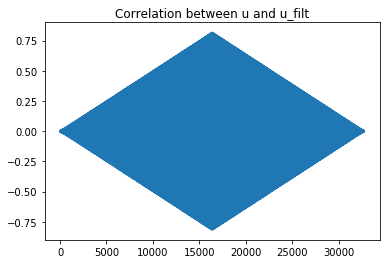

In [4]:
OFFSET_ADJUSTMENT_ENABLED = False

window = int(3/8. * u.size)

# find offset
plt.figure()
plt.title("Correlation between u and u_filt")
corr = np.correlate(u[window:-window], u_hat[window:-window], 'full')
corrH = np.correlate(u[window:-window], u_hatH[window:-window], 'full')

offset = int(len(corr)/2) - np.argmax(corr)
offsetH = int(len(corrH)/2 - np.argmax(corrH))

plt.plot(corr)
print("Offset due to filtering = ", offset)
print("Offset due to filtering H = ", offsetH)


if OFFSET_ADJUSTMENT_ENABLED:
    u_hat = np.roll(u_hat, -offset)
    u_hatH = np.roll(u_hatH, -offsetH)   
    

# IIR Filter

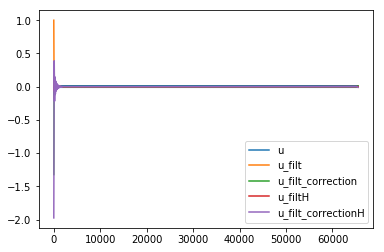

In [5]:
# filter noise-shaped mash output signal
u_filt = u_hat.copy()
u_filtH = u_hatH.copy()

f3dB = 1./(2. * OSR) 
# b, a = signal.iirfilter(16, f3dB, btype='lowpass', analog=False, ftype='butter')

N = 17
wp = f3dB
ws = (1. + 0.1) * wp
gpass = 0.01
gstopp = DR
sos = signal.iirfilter(N, wp, rs = gstopp, btype='lowpass', analog=False, ftype='cheby2', output="sos")


n_filter_applied = 1
for ii in range(n_filter_applied):
#     u_filt = mash.lowPassFilter(u_filt)
#     u_filt = signal.filtfilt(b, a, u_filt)
#     u_filt = signal.sosfilt(sos, u_filt)
    u_filt = signal.sosfiltfilt(sos, u_filt)
    u_filtH = signal.sosfiltfilt(sos, u_filtH)

    
    
correction = np.dot(u[window:-window], u_filt[window:-window]) / (np.linalg.norm(u_filt[window:-window])**2)
correctionH = np.dot(u[window:-window], u_filtH[window:-window]) / (np.linalg.norm(u_filtH[window:-window])**2)

u_filt_correction = u_filt * correction
u_filt_correctionH = u_filtH * correctionH

plt.figure()
plt.plot(u, label="u")
plt.plot(u_filt, label="u_filt")
plt.plot(u_filt_correction, label="u_filt_correction")

plt.plot(u_filtH, label="u_filtH")
plt.plot(u_filt_correctionH, label="u_filt_correctionH")

plt.legend()

# FIR Filter

[0, 0.015625, 0.0203125, 1]
[1, 1, 6.4546942321498e-06, 0]
[5.73482933e-08 6.29915568e-08 6.85008998e-08 ... 6.85008998e-08
 6.29915568e-08 5.73482933e-08]


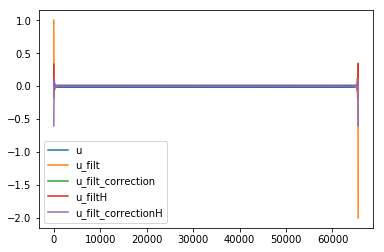

In [6]:
# filter noise-shaped mash output signal
u_filt = u_hat.copy()
u_filtH = u_hatH.copy()

f3dB = 1./(2. * OSR) 
# b, a = signal.iirfilter(16, f3dB, btype='lowpass', analog=False, ftype='butter')

N = 10000
diff = f3dB * 0.3
f = [0, f3dB, f3dB + diff, 1]
dr = 10**(-DR/20.)
amp = [1, 1, dr, 0]
fir = signal.firwin2(N, f, amp)

print(f)
print(amp)
print(fir)

n_filter_applied = 1
for ii in range(n_filter_applied):
    u_filt = signal.filtfilt(fir, [1], u_filt)
    u_filtH = signal.filtfilt(fir, [1], u_filtH)

    
    
correction = np.dot(u[window:-window], u_filt[window:-window]) / (np.linalg.norm(u_filt[window:-window])**2)
correctionH = np.dot(u[window:-window], u_filtH[window:-window]) / (np.linalg.norm(u_filtH[window:-window])**2)

u_filt_correction = u_filt * correction
u_filt_correctionH = u_filtH * correctionH

plt.figure()
plt.plot(u, label="u")
plt.plot(u_filt, label="u_filt")
plt.plot(u_filt_correction, label="u_filt_correction")

plt.plot(u_filtH, label="u_filtH")
plt.plot(u_filt_correctionH, label="u_filt_correctionH")

plt.legend()

# Error code

/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/home/rakeusch/.conda/envs/rakeusch_3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


MSE is -43.010287 dB
MSE with Correction is -43.010300 dB
MSE H is -43.010213 dB
MSE H with Correction is -43.010361 dB


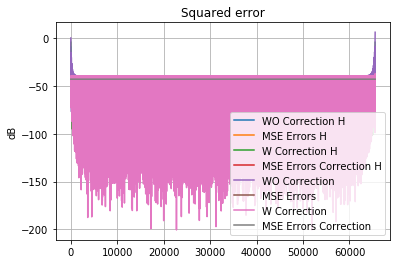

In [7]:

# Squared Error Plot
plt.figure()
error_abs = np.abs(u - u_filt)**2
error_abs -= np.mean(u-u_filt)**2
error_abs_correction = np.abs(u - u_filt_correction)**2

error_absH = np.abs(u - u_filtH)**2
error_absH -= np.mean(error_absH)**2
error_abs_correctionH = np.abs(u - u_filt_correctionH)**2


plt.plot(10 * np.log10(error_absH), label="WO Correction H")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_absH[window:-window])/error_absH[window:-window].size), label="MSE Errors H")
plt.plot(10 * np.log10(error_abs_correctionH), label="W Correction H")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_abs_correctionH[window:-window])/error_abs_correctionH[window:-window].size), label="MSE Errors Correction H")

plt.plot(10 * np.log10(error_abs), label="WO Correction")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_abs[window:-window])/error_abs[window:-window].size), label="MSE Errors")
plt.plot(10 * np.log10(error_abs_correction), label="W Correction")
plt.plot(np.ones(u.size) * 10 * np.log10(np.sum(error_abs_correction[window:-window])/error_abs_correction[window:-window].size), label="MSE Errors Correction")


plt.grid(True)
plt.legend()
plt.ylabel("dB")
plt.title("Squared error")

length = u[window:-window].size
error = u[window:-window] - u_filt[window:-window]
error_correction = u[window:-window] - u_filt_correction[window:-window]

errorH = u[window:-window] - u_filtH[window:-window]
error_correctionH = u[window:-window] - u_filt_correctionH[window:-window]

# error -= error.mean()
# error_correction -= error_correction.mean()

# errorH -= errorH.mean()
# error_correctionH -= error_correctionH.mean()


mse = np.sum(np.abs(error)**2)
mse_correction = np.sum(np.abs(error_correction)**2)
mse /= length
mse_correction /= length

mseH = np.sum(np.abs(errorH)**2)
mse_correctionH = np.sum(np.abs(error_correctionH)**2)
mseH /= length
mse_correctionH /= length


print("MSE is %f dB" % (10 * np.log10(mse)))
print("MSE with Correction is %f dB" % (10 * np.log10(mse_correction)))

print("MSE H is %f dB" % (10 * np.log10(mseH)))
print("MSE H with Correction is %f dB" % (10 * np.log10(mse_correctionH)))

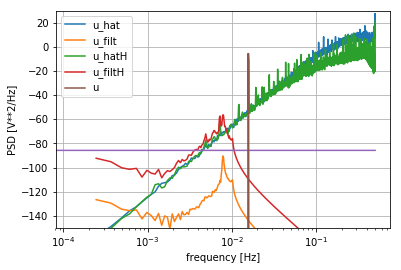

[0.00000000e+00 1.22070312e-04 2.44140625e-04 ... 4.99755859e-01
 4.99877930e-01 5.00000000e-01]


In [8]:
# plot psd of input signal
f, psd_u = signal.welch(u, 1, nperseg=1024 * 8)
f, psd_u_hat = signal.welch(u_hat, 1, nperseg=1024 * 8)
f, psd_u_filt = signal.welch(u_filt_correction, 1, nperseg=1024 * 8)

f, psd_u_hatH = signal.welch(u_hatH, 1, nperseg=1024 * 8)
f, psd_u_filtH = signal.welch(u_filt_correctionH, 1, nperseg=1024 * 8)



window2 = 2

plt.figure()
plt.grid(True)
plt.semilogx(f[window2:], 10 * np.log10(psd_u_hat[window2:]), label='u_hat')
plt.semilogx(f[window2:], 10 * np.log10(psd_u_filt[window2:]), label='u_filt')

plt.semilogx(f[window2:], 10 * np.log10(psd_u_hatH[window2:]), label='u_hatH')
plt.semilogx(f[window2:], 10 * np.log10(psd_u_filtH[window2:]), label='u_filtH')

plt.semilogx(f, np.ones_like(f) * 10 * np.log10(10**(-DR/10.) * (OSR * 2)))
plt.semilogx(f[window2:], 10 * np.log10(psd_u[window2:]), label='u')
# for index in range(1, systemOrder + 1):
#     offset = 1 * 6.02 + 1.76 + 10 * np.log10(2 * index + 1) - 20 * index * np.log10(np.pi)
#     plt.semilogx(f, offset + 10 * (2 * index + 1) * np.log10(OSR), label="order %i" % (index ))

plt.ylim([-150, 30])
# plt.xlim([0,0.1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.show()

print(f)

In [29]:
def calculateSNR(psd, offset):
    tmp = np.argmax(psd)
    fPeakIndex = np.arange(tmp - offset/2, tmp + offset/2, dtype=np.int)
    print(fPeakIndex)
    signalPower = np.sum(psd[fPeakIndex])
    print(np.delete(np.arange(psd.size), fPeakIndex)[tmp-10:tmp+10])
    noisePower = np.sum(psd[np.delete(np.arange(psd.size), fPeakIndex)])
    snr = signalPower/noisePower
    return snr, signalPower, noisePower

1024 65536
[2.21743687e-07 1.10653220e-07 2.21887872e-13 ... 4.68579819e-21
 4.65947282e-21 4.62841207e-21]
[52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
SNR, SignalPower, NoisePower [dB]: 13.59244621698984, -86.01587220320772, -99.60831842019756


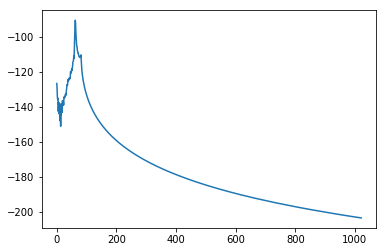

In [35]:
fBI = np.int(1./(OSR * 2) * n_samples)
print(fBI, n_samples)
plt.figure()
plt.plot(10 * np.log10(np.abs(psd_u_filt[2:fBI])))
print(psd_u_filt[:fBI])
snr, signalPower, noisePower = calculateSNR(psd_u_filt[2:fBI], 20)
print("SNR, SignalPower, NoisePower [dB]: %s, %s, %s" % (10 * np.log10(snr), 10 * np.log10(signalPower), 10 *  np.log10(noisePower)))

# Summary

In [11]:
print('Expected MSE: %f\nEffective Number of bits: %s' % (-DR, ENOB))
print("MSE is %f dB" % (10 * np.log10(mse)))
print("MSE with Correction is %f dB" % (10 * np.log10(mse_correction)))

print("MSE H is %f dB" % (10 * np.log10(mseH)))
print("MSE H with Correction is %f dB" % (10 * np.log10(mse_correctionH)))

Expected MSE: -103.802487
Effective Number of bits: 16.95057915629368
MSE is -43.010287 dB
MSE with Correction is -43.010300 dB
MSE H is -43.010213 dB
MSE H with Correction is -43.010361 dB
